<a href="https://colab.research.google.com/github/sergfer26/Proyectos-II/blob/main/semana6/nn_har_conv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human activity recognition (HAR) using convolutional neural networks
(Reconocimiento de actividades usando redes neuronales convolucionales)

## Contexto

Un total de 30 personas en el rango de edades 19-48 años participaron en una investigación donde realizaron 6 distintas actividades de movimiento, estás actividades son: *standing,  sitting,  laying,  walking,  walking upstairs* and *walking  downstairs*.

Para registrar los movimientos de los participantes se utilizp el acelerometro triaxial del *smartphone* Samsung I9100 Galaxy S II. Las señales de aceleración registradas a una frecuencia de 50Hz.

Se segmentaron las señales en ventanas de 2.56 segundos. También se procesesaron por la transformada rápida de Fourier (FFT) y se obtuvieron ventanas de 128 ciclos.

**Objetivo**: A partir de las señales de aceleración y velocidad triaxiales entrenar una red neuronal con capas convolucionales que sea capza de identificar la actividad correspondinte a su actividad.

In [ ]:
import time
import torch
import matplotlib
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
matplotlib.style.use('ggplot')


## Revisar disponibilidad del gpu

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Carga de datos

La siguiente función carga las etiquetas de las muestras.

In [ ]:
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

La siguiente función carga los 9 rasgos que caracterizan cada una de las 128 ventanas que tiene cada muestra.

Los 9 ragos se dividen en dos partes:

* Aceleración triaxial (aceleración total) y la aceleración estimada del cuerpo (6 rasgos).
* Velocidad angular triaxial del giroscopio (3 rasgos).

$$\mathcal{D} = \{X, y | X\in \mathbb{R}^{9\times 128}, y \in C \},$$
donde
$$
\begin{align}
C &= \{0, 1, 2, 3, 4, 5, 6\}\\
X &= [a_x, a_y, a_z, \hat a_x, \hat a_y, \hat a_z, v_x, v_y, v_z]
\end{align}
$$

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded

La siguiente función carga las muestras de cada un de los dos conjuntos: entrenamiento y prueba.

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	x = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return x, y

La siguiente función carga los conjuntos de entrenamiento y prueba.

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	train_x, train_y = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	test_x, test_y = load_dataset_group('test', prefix + 'HARDataset/')
	train_y = train_y - 1
	test_y = test_y - 1
	return train_x, train_y, test_x, test_y

### Conexión con base de datos en Google Drive

In [ ]:
from google.colab import drive # Colab
drive.mount('/content/drive') # Colab
root = "/content/drive/MyDrive/Classroom/Proyectos II Grupo 6034/data-sets/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_x, train_y, test_x, test_y = load_dataset(prefix=root)

In [ ]:
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)
print('test_x shape:', test_x.shape)
print('test_y shape:', test_y.shape)

train_x shape: (7352, 128, 9)
train_y shape: (7352, 1)
test_x shape: (2947, 128, 9)
test_y shape: (2947, 1)


In [ ]:
clases = {0: 'Walking', 1: 'Walking Upstairs', 2: 'Walking Downstairs', 3: 'Sitting', 4: 'Standing', 
       5: 'Laying'}

## Definición del conjunto de datos

Dimensiones de Pytorch := $[k, c, v] \rightarrow$ conv1d \\
Dimensiones de Pytorch := $[k, c, h, w] \rightarrow$ conv2d

In [ ]:
z = torch.tensor(train_x).to(torch.float32)
train_x_tensor = torch.transpose(z, 2, 1)
train_y_tensor = torch.tensor(train_y).to(torch.long)

z = torch.tensor(test_x).to(torch.float32)
test_x_tensor = torch.transpose(z, 2, 1)
test_y_tensor = torch.tensor(test_y).to(torch.long)

In [ ]:
train_set = TensorDataset(train_x_tensor, train_y_tensor.flatten()) #flatten para que sea vector
test_set = TensorDataset(test_x_tensor, test_y_tensor.flatten())

### Dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

## Exploración de los datos

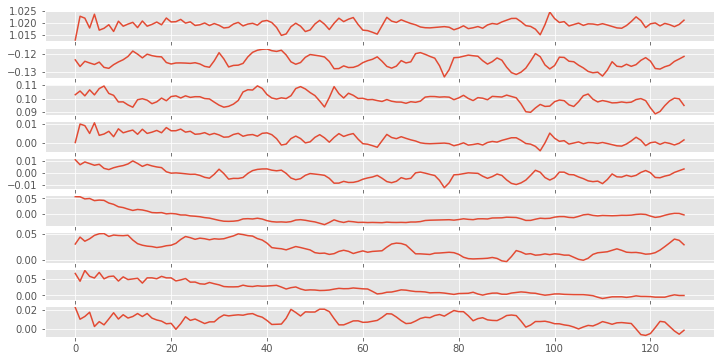

Standing


In [ ]:
sample = 0
fig, ax = plt.subplots(9, 1, figsize=(12, 6))
for channel in range(9):
  x = train_x[sample, :, channel]
  ax[channel].plot(x)

plt.show()
print(clases[train_y[sample, 0]])

## Definición del modelo

In [ ]:
n_timesteps = train_x.shape[1]
n_features = train_x.shape[2]

Introducimos la capa `nn.BatchNorm1d` que consiste en normalizar las entradas de acuerdo al *batch*. A cada valor $\mathbf{x} \in X_{(batch)}$ se le aplica la siguiente transformación:

$$\mathbf{y} = \frac{\mathbf{x} - \hat\mu}{\sqrt{\hat\sigma^2 + \epsilon}}\cdot \gamma + \beta$$
donde
 * $\gamma$ y \beta son parámetros ajustable para el aprendizaje. 




In [ ]:

model = nn.Sequential(
    OrderedDict([
                 ('z1', nn.Conv1d(n_features, 64, kernel_size=3)),
                 ('b1', nn.BatchNorm1d(64)),
                 ('h1', nn.Sigmoid()),
                 ('z2', nn.Conv1d(64, 64, kernel_size=3)),
                 ('h2', nn.Sigmoid()),
                 ('d2', nn.Dropout(p=0.5)),
                 ('p1', nn.MaxPool1d(kernel_size=2)),
                 ('b2', nn.BatchNorm1d(64)),
                 ('f2', nn.Flatten()),
                 ('z3', nn.Linear(64 * 62, 64)),
                 ('d3', nn.Dropout(p=0.2)),
                 ('b3', nn.BatchNorm1d(64)),
                 ('h3', nn.Sigmoid()), 
                 ('z4', nn.Linear(64, 6))    
    ]))

In [ ]:
model = model.to(device)

In [ ]:
print(model)

Sequential(
  (z1): Conv1d(9, 64, kernel_size=(3,), stride=(1,))
  (b1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (h1): Sigmoid()
  (z2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (h2): Sigmoid()
  (d2): Dropout(p=0.5, inplace=False)
  (p1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (f2): Flatten(start_dim=1, end_dim=-1)
  (z3): Linear(in_features=3968, out_features=64, bias=True)
  (d3): Dropout(p=0.2, inplace=False)
  (b3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (h3): Sigmoid()
  (z4): Linear(in_features=64, out_features=6, bias=True)
)


## Función objetivo y optimizador

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
criterion = nn.CrossEntropyLoss()

## Entrenamiento

1. Ajuste de paramétros por época.

In [ ]:
def fit(model, dataloader, optimizer, criterion, pbar, train=True):
  running_loss = 0.0
  correct = 0
  total = 0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    X, Y = X.to(device), Y.to(device)
    if train:
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
    pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
    pbar.update(Y.shape[0])
  return avg_loss, acc

2. Entrenamiento del modelo.

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
  train_time = 0
  epoch_loss = list(); epoch_acc = list()
  val_loss = list(); val_acc = list()

  n_train = len(train_loader.dataset)
  n_val = len(val_loader.dataset)
  model.train() # -> aplica drop si lo tiene el modelo y lleva registro de los gradientes
  for epoch in range(epochs):
    start_time = time.time()
    with tqdm(total=n_train, position=0) as pbar_train:
      pbar_train.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - train')
      pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
      loss_train, acc_train = fit(model, train_loader, optimizer, criterion, pbar_train)
      train_time +=  time.time() - start_time
    model.eval() # -> de esta forma no incluye dropout, ni lleva registro de los gradientes
    with tqdm(total=n_val, position=0) as pbar_val:
      pbar_val.set_description(f'Epoch {epoch + 1}/'+str(epochs)+' - val')
      pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
      loss_val, acc_val = fit(model, val_loader, optimizer, criterion, pbar_val, train=False)

    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)

    val_loss.append(loss_val)
    val_acc.append(acc_val)

  return epoch_loss, epoch_acc, val_loss, val_acc, train_time

In [ ]:
EPOCHS = 100
epoch_loss, epoch_acc, val_loss, val_acc, train_time = train(model, train_loader, test_loader, optimizer, criterion, EPOCHS)
print("\n --- %s seconds ---", train_time)

Epoch 1/100 - train:   0%|          | 0/7352 [00:00<?, ?it/s, acc=0.0, avg_loss=0.0]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch 100/100 - val: 100%|██████████| 2947/2947 [00:00<00:00, 3983.79it/s, acc=0.8999, avg_loss=0.7958]


 --- %s seconds --- 264.5142958164215


### Evaluación del entrenamiento

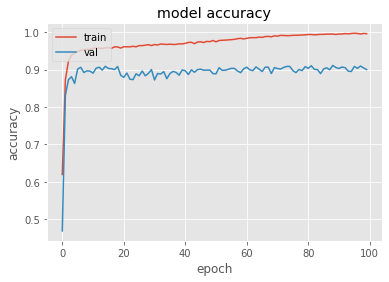

In [ ]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

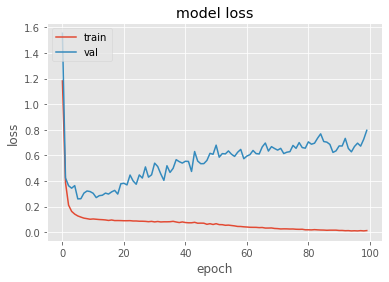

In [ ]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()